<a href="https://colab.research.google.com/github/DeanHazineh/Pytorch-Deep_Learning_Examples/blob/main/CIFAR10_Simple_CNN_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

The goal of this script is to practice training a simple CNN for the CIFAR 10 dataset. I present a few basic examples and tests.

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from tqdm.autonotebook import tqdm
import time
import os

print(torch.__version__)
torch.cuda.is_available()

1.13.1+cu116


True

## Load the CIFAR10 Dataset

First we load the CIFAR dataset as exemplified in the example scripts. 

In [2]:
def load_cifar(datadir='./data_cache'): # will download ~400MB of data into this dir. Change the dir if neccesary. If using paperspace, you can make this /storage
    train_ds = ds.CIFAR10(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.CIFAR10(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = torch.Tensor(np.transpose(dataset.data, (0, 3, 1, 2))).float() / 255.0  # [0, 1]
        Y = torch.Tensor(np.array(dataset.targets)).long()
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

def make_loader(dataset, batch_size=128):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=4, pin_memory=True)

X_tr, Y_tr, X_te, Y_te = load_cifar()
train_dl = make_loader(TensorDataset(X_tr, Y_tr))
test_dl = make_loader(TensorDataset(X_te, Y_te))

## Print some information about the dataset sizes
print("x-train shape: ", X_tr.shape)
print("y-train shape: ", Y_tr.shape)
print("x-test shape: ", X_te.shape)
print("y-test shape: ", Y_te.shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data_cache/cifar-10-python.tar.gz to ./data_cache
Files already downloaded and verified
x-train shape:  torch.Size([50000, 3, 32, 32])
y-train shape:  torch.Size([50000])
x-test shape:  torch.Size([10000, 3, 32, 32])
y-test shape:  torch.Size([10000])


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Define Train Helper

I then introduce my own code to train a passed in CNN model on the CIFAR data. I have added extra functionality such as the ability to save model checkpoints and load so we can resume training later. This is sometimes helpful. A helper function for plotting is also written. All of this can be skipped as it will be used/demod later.

In [3]:
def run_training(model, opt, lr, epochs, path, saveAtEpoch=None, verbose=True):
    # Default to SGD optimizer and standard cross-entropy loss fn
    model.cuda() # move model to cuda so optimizer can load from checkpoint correctly
    opt = opt(model.parameters(), lr)
    loss_func = nn.CrossEntropyLoss()
    
    # Hold training history vectors
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    # If path exists then load checkpoint
    print("Checking for Model Checkpoint")
    if os.path.exists(path):
        print("Loading model checkpoint at:", path)
        checkpoint = torch.load(path, map_location='cuda')
        
        model.load_state_dict(checkpoint['model_state_dict'])
        opt.load_state_dict(checkpoint['optimizer_state_dict'])
        train_loss_history = checkpoint['train_loss_history'] 
        train_acc_history = checkpoint['train_acc_history'] 
        test_loss_history = checkpoint['test_loss_history'] 
        test_acc_history = checkpoint['test_acc_history'] 

    # Loop over Epochs
    for i in tqdm(range(epochs), desc="Epoch", position=0):
        time.sleep(0.05)
        # Call training step
        train_loss, train_acc = train_epoch(model, train_dl, opt, loss_func)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Evaluate on test set
        test_loss, test_acc = evaluate(model, test_dl, loss_func=loss_func)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

        # Save checkpoint
        if saveAtEpoch is not None:
            if i>0 and np.mod(i+1, saveAtEpoch)==0:
                print("Saving Model Checkpoint at Epoch: ", i)
                torch.save({
                    'model_state_dict':model.state_dict(),
                    'optimizer_state_dict': opt.state_dict(),
                    'train_loss_history': train_loss_history,
                    'train_acc_history': train_acc_history,
                    'test_loss_history': test_loss_history,
                    'test_acc_history': test_acc_history
                }, path)

        if verbose: 
            print(f'Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f} \t Test Acc: {test_acc:.3f}')

    # return trained model and dictionary of loss
    return model, {'train_loss_history': train_loss_history, 'train_acc_history': train_acc_history, 'test_loss_history':test_loss_history, 'test_acc_history':test_acc_history}


def train_epoch(model, train_dl : DataLoader, opt, loss_func):
    # Set the model parameters to trainable and move to CUDA
    model.train()
    model.cuda()

    netLoss = 0.0
    nCorrect = 0
    nTotal = 0
    for i, (xB, yB) in enumerate(tqdm(train_dl, desc="Batch", position=1, leave=False)):
        # Zero gradients at start of each epoch since it defaults to grad accumulation
        opt.zero_grad()
        
        # Forward computation
        xB, yB = xB.cuda(), yB.cuda()
        outputs = model(xB)
        loss = loss_func(outputs, yB)

        # Compute gradients and update variables
        loss.backward()
        opt.step()
        netLoss += loss * len(xB)
        
        # Compute the minibatch training accuracy for logging
        with torch.no_grad():
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yB).float().sum()
            nTotal += preds.size(0)
    
    train_acc = nCorrect.cpu().item()/nTotal
    avg_loss = netLoss.cpu().item()/nTotal
    return avg_loss, train_acc


def evaluate(model, test_dl, loss_func):
    # Freeze the model and move to gpu
    model.eval()
    model.cuda()

    nCorrect = 0.0
    nTotal = 0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            xb, yb = xb.cuda(), yb.cuda()
            outputs = model(xb)
            loss = loss_func(outputs, yb) * len(xb)

            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yb).float().sum()
            net_loss += loss
            nTotal += preds.size(0)

    acc = nCorrect.cpu().item() / float(nTotal)
    loss = net_loss.cpu().item() / float(nTotal)
    return loss, acc


def plot_loss_history(train_hist: list, labels: list):
    if not isinstance(train_hist, list):
        raise TypeError("input must be list of dictionaries")
    if not isinstance(labels, list):
        raise TypeError("input labels must be list")
  
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    lines = ["-","--","-.",":","."]
    linecycler = cycle(lines)
    line_used = []

    # Loop over passed in data
    for history in train_hist:
        marker = next(linecycler)
        line_used.append(plt.Line2D([], [], color='k', linestyle=marker, markersize=10))

        train_loss = history['train_loss_history']
        test_loss = history['test_loss_history']
        train_acc = history['train_acc_history']
        test_acc = history['test_acc_history']
        epoch = np.arange(0, len(train_loss), 1)
        
        # Plot Model Loss
        ax1.plot(epoch, train_loss, marker, color='b')
        ax1.plot(epoch, test_loss, marker, color='r')
        ax1.set_title("Model loss")
        ax1.set_ylabel("CrossEntropy Loss")
        ax1.set_xlabel("epoch");
        ax1.legend()

        # Plot Model Accuracy
        ax2.plot(epoch, train_acc, marker, color='b', label="train")
        ax2.plot(epoch, test_acc, marker, color='r', label='test')
        ax2.set_title("Model Accuracy")
        ax2.set_xlabel("epoch")
        ax2.set_ylabel("Classification Accuracy")
    
    # Add legend for train vs test
    # Add legend for comparison sets
    ax2.legend([plt.Line2D([], [], color='b', linestyle='-', markersize=10), plt.Line2D([], [], color='r', linestyle='-', markersize=10)], ['train', 'test'])
    ax1.legend(line_used, labels)
    return

# Main Training and Exploration

## Define and Train the Example Myrtle 5 Network

First, I train the example network (dubed the Myrtle5 CNN). This is mainly to confirm that everything is set up properly. As expected, we reach about 85% accuracy once converged.

Out of curiosity and for a future benchmark, I test two different learning rates using a SGD optimizer. I find that in this case, there is not much sensitivity to the learning rate as both traning sessions converge to similar steady states. 

In [4]:
# This is the Myrtle5 network by David Page (https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/)
# Flatten is basically just squeeze where we assume ahead of time the remaining dimensions 2: are singular
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

def Myrtle5(c=64, num_classes=10):
    ''' Returns a 5-layer CNN with width parameter c. '''
    return nn.Sequential(
        # Layer 0
        nn.Conv2d(3, c, kernel_size=3, stride=1,
                  padding=1, bias=True),
        nn.BatchNorm2d(c),
        nn.ReLU(),

        # Layer 1
        nn.Conv2d(c, c*2, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*2),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 2
        nn.Conv2d(c*2, c*4, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*4),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 3
        nn.Conv2d(c*4, c*8, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*8),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 4
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c*8, num_classes, bias=True)
    )

In [11]:
model, myrtle5_SGD1 = run_training(
    Myrtle5(),
    torch.optim.SGD,
    lr=1e-1,
    epochs=30,
    path = "/content/Myrtle5_SGD1.pt",
    saveAtEpoch=10,
    verbose=False)

model, myrtle5_SGD2 = run_training(
    Myrtle5(),
    torch.optim.SGD,
    lr=1e-2,
    epochs=30,
    path = "/content/Myrtle5_SGD2.pt",
    saveAtEpoch=10,
    verbose=False)

Checking for Model Checkpoint


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  19


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  29
Checking for Model Checkpoint


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  19


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  29


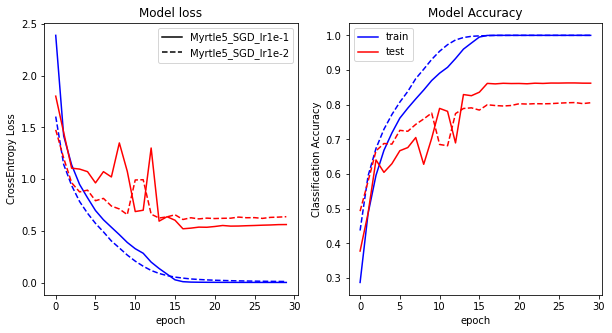

In [12]:
plot_loss_history([myrtle5_SGD1, myrtle5_SGD2], ["Myrtle5_SGD_lr1e-1", "Myrtle5_SGD_lr1e-2"])

## Modification: Explore Switch to ADAM Optimizer

The first modification I want to consider is switching to the ADAM optimizer, as was nicely discussed in the survey "Optimization for deep learning: theory and algorithms". We expect that an ADAM optimizer should converge faster than the SGD optimizer. Below, I train the same Myrtle5 model using ADAM and for multiple learning rates. 

In all cases tested, I do find that the ADAM optimizer converges faster than SGD (both shown in loss and accuracy). 

In [14]:
_, myrtle5_ADAM2 = run_training(
    Myrtle5(),
    torch.optim.Adam,
    lr=1e-2,
    epochs=20,
    path = "/content/Myrtle5_ADAM2.pt",
    saveAtEpoch=10,
    verbose=False)
    
_, myrtle5_ADAM3 = run_training(
    Myrtle5(),
    torch.optim.Adam,
    lr=1e-3,
    epochs=20,
    path = "/content/Myrtle5_ADAM3.pt",
    saveAtEpoch=10,
    verbose=False)
       
_, myrtle5_ADAM4 = run_training(
    Myrtle5(),
    torch.optim.Adam,
    lr=1e-4,
    epochs=20,
    path = "/content/Myrtle5_ADAM4.pt",
    saveAtEpoch=10,
    verbose=False)

Checking for Model Checkpoint


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  19
Checking for Model Checkpoint


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  19
Checking for Model Checkpoint


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  19


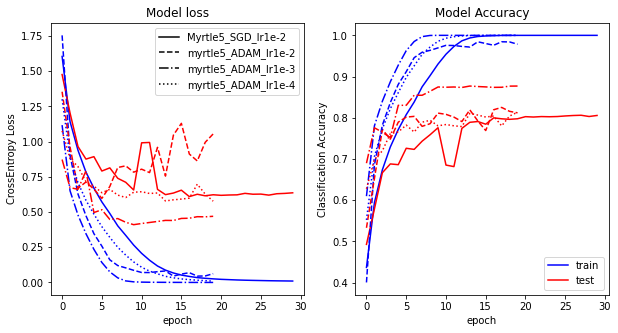

In [15]:
plot_loss_history([myrtle5_SGD2, myrtle5_ADAM2, myrtle5_ADAM3, myrtle5_ADAM4], ['Myrtle5_SGD_lr1e-2', 'myrtle5_ADAM_lr1e-2', 'myrtle5_ADAM_lr1e-3', 'myrtle5_ADAM_lr1e-4'])

## Modification: Changes to the model depth

I like the ADAM optimizer finding so we can stick with that. As another simple and quick test, we may explore to see how the performance changes with modifications to the CNN channel depth. For readability, I like the idea of changes which can reuse the code already written above! 

The observations are mostly as expected. There starts to reach a point of diminishing returns with increasing model depth (e.g. going from 64 to 124 channels presents little change to the converged test accuracy). The jump from c=16 to c=32 has much better gain per compute. 


In [16]:
_, myrtle5_C128 = run_training(
    Myrtle5(c=128),
    torch.optim.Adam,
    lr=1e-3,
    epochs=15,
    path = "/content/Myrtle5_C128.pt",
    saveAtEpoch=10,
    verbose=False)

_, myrtle5_C64 = run_training(
    Myrtle5(c=64),
    torch.optim.Adam,
    lr=1e-3,
    epochs=15,
    path = "/content/Myrtle5_C64.pt",
    saveAtEpoch=10,
    verbose=False)
    
_, myrtle5_C32 = run_training(
    Myrtle5(c=32),
    torch.optim.Adam,
    lr=1e-3,
    epochs=15,
    path = "/content/Myrtle5_C32.pt",
    saveAtEpoch=10,
    verbose=False)
       
_, myrtle5_ADAM16 = run_training(
    Myrtle5(c=16),
    torch.optim.Adam,
    lr=1e-3,
    epochs=15,
    path = "/content/Myrtle5_C16.pt",
    saveAtEpoch=10,
    verbose=False)

Checking for Model Checkpoint


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Checking for Model Checkpoint


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Checking for Model Checkpoint


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Checking for Model Checkpoint


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

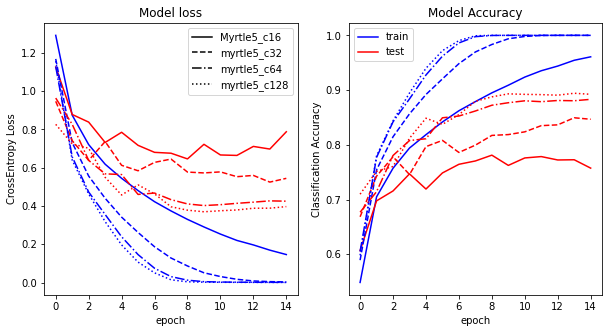

In [17]:
plot_loss_history([myrtle5_ADAM16, myrtle5_C32, myrtle5_C64, myrtle5_C128], ['Myrtle5_c16', 'myrtle5_c32', 'myrtle5_c64', 'myrtle5_c128'])

## Modification: BatchNormalization and Learning Rate

As an additional test, I now consider the point of removing the batch-normalization layers. These layers normalize the input (in the channel dimension) to control the mean and standard deviation. This makes a significant difference to regularize things and can enable better training since signals could be diminished otherwise by typical activation functions if initial conditions are sub-optimal. 

Myrtle5 (modified to remove batch normalization) with c=64 is tested. I consider the SGD algorithm and four instances of ADAM optimizer with different learning rates. We expect much greater sensitivity to learning rate and optimizer selection when batch normalization is removed. 

My findings are displayed in the plot. Indeed I find that training becomes much trickier! For the ADAM optimizer, a learning rate of 1e-3 converged to the best test accuracy but lr=1e-2 and 1e-4 were both lower. With batch normalizations, we found a different result where the converged accuracy did not reduce when the learning rate was made smaller. 

In [18]:
# Introduce the Myrtle5 Network again but remove the batch normalization layers
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

def Myrtle5_NoBatchNorm(c=64, num_classes=10):
    return nn.Sequential(
        # Layer 0
        nn.Conv2d(3, c, kernel_size=3, stride=1,
                  padding=1, bias=True),
        nn.ReLU(),

        # Layer 1
        nn.Conv2d(c, c*2, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 2
        nn.Conv2d(c*2, c*4, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 3
        nn.Conv2d(c*4, c*8, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 4
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c*8, num_classes, bias=True)
    )

In [21]:
model, myrtle5_NoB_SGD2 = run_training(
    Myrtle5(),
    torch.optim.SGD,
    lr=1e-2,
    epochs=15,
    path = "/content/myrtle5_NoB_SGD2.pt",
    saveAtEpoch=10,
    verbose=False)

_, myrtle5_NoB_ADAM2 = run_training(
    Myrtle5_NoBatchNorm(),
    torch.optim.Adam,
    lr=1e-2,
    epochs=15,
    path = "/content/myrtle5_NoB_ADAM2.pt",
    saveAtEpoch=10,
    verbose=False)
    
_, myrtle5_NoB_ADAM3 = run_training(
    Myrtle5_NoBatchNorm(),
    torch.optim.Adam,
    lr=1e-3,
    epochs=15,
    path = "/content/myrtle5_NoB_ADAM3.pt",
    saveAtEpoch=10,
    verbose=False)
       
_, myrtle5_NoB_ADAM4 = run_training(
    Myrtle5_NoBatchNorm(),
    torch.optim.Adam,
    lr=1e-4,
    epochs=15,
    path = "/content/myrtle5_NoB_ADAM4.pt",
    saveAtEpoch=10,
    verbose=False)
    

Checking for Model Checkpoint


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Checking for Model Checkpoint


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Checking for Model Checkpoint


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Checking for Model Checkpoint


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Saving Model Checkpoint at Epoch:  9


Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

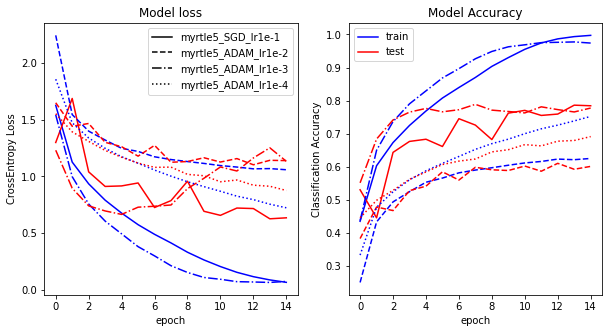

In [22]:
plot_loss_history([myrtle5_NoB_SGD2, myrtle5_NoB_ADAM2, myrtle5_NoB_ADAM3, myrtle5_NoB_ADAM4], ["myrtle5_SGD_lr1e-1", "myrtle5_ADAM_lr1e-2",  "myrtle5_ADAM_lr1e-3",  "myrtle5_ADAM_lr1e-4"])